In [ ]:
!pip install ucimlrepo numpy pandas scikit-learn scikit-learn-extra matplotlib seaborn pyclustering

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=5500cd8cd74481650cfa7e54c4f20a514d338089c7be055d588afacde654f5dc
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering


### Data fetching

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
iris = fetch_ucirepo(id=53)
wine = fetch_ucirepo(id=109)


In [ ]:
import pandas as pd
import numpy as np

# Convert features and targets into DataFrames
iris_data = pd.DataFrame(iris.data.features, columns=iris.data.feature_names)
iris_labels = pd.DataFrame(iris.data.targets, columns=iris.data.target_names)

wine_data = pd.DataFrame(wine.data.features, columns=wine.data.feature_names)
wine_labels = pd.DataFrame(wine.data.targets, columns=wine.data.target_names)

# Optionally, combine features and target into a single DataFrame
iris_dataset = pd.concat([iris_data, iris_labels], axis=1)
iris_dataset.head()

wine_dataset = pd.concat([wine_data, wine_labels], axis=1)
wine_dataset.head()


,Alcohol,Malicacid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,0D280_0D315_of_diluted_wines,Proline,class
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_data)
wine_scaled = scaler.fit_transform(wine_data)

### Partition-Based Clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids

# Helper function: Run KMeans (basic and k-means++)
def run_kmeans(data, n_clusters=3, init='k-means++', plot=True):
    model = KMeans(n_clusters=n_clusters, init=init, random_state=42)
    labels = model.fit_predict(data)

    if plot:
        plt.figure(figsize=(8, 6))
        # Plot the data points with the cluster colors
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data Points')

        # Plot centroids in red 'X'
        plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')

        plt.title('KMeans Clustering')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()

    return model, labels

# Helper function: Bisecting KMeans
def run_bisecting_kmeans(data, n_clusters=3, plot=True):
    clusters = [data]
    labels = np.zeros(len(data), dtype=int)

    for cluster_id in range(1, n_clusters):
        # Find largest cluster
        largest_cluster_idx = np.argmax([len(c) for c in clusters])
        largest_cluster = clusters.pop(largest_cluster_idx)

        # Apply KMeans on the largest cluster
        model = KMeans(n_clusters=2, random_state=42)
        sub_labels = model.fit_predict(largest_cluster)

        # Split the cluster into two
        clusters.insert(largest_cluster_idx, largest_cluster[sub_labels == 0])
        clusters.insert(largest_cluster_idx + 1, largest_cluster[sub_labels == 1])

    final_labels = np.zeros(len(data), dtype=int)
    start = 0
    for i, c in enumerate(clusters):
        for _ in range(len(c)):
            final_labels[start] = i
            start += 1

    if plot:
        plt.figure(figsize=(8, 6))
        # Plot the data points with the cluster colors
        plt.scatter(data[:, 0], data[:, 1], c=final_labels, cmap='viridis', alpha=0.6, label='Data Points')
        plt.title('Bisecting KMeans Clustering')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()

    return final_labels

# Helper function: Run KMedoids (using pyclustering)
def run_kmedoids_pyclustering(data, n_clusters=3, plot=True):
    # Initializing the medoids (random indices of data points)
    initial_medoids = np.random.choice(len(data), n_clusters, replace=False)

    # Running the KMedoids clustering
    kmedoids_instance = kmedoids(data, initial_medoids)
    kmedoids_instance.process()

    # Get the clusters from pyclustering
    clusters = kmedoids_instance.get_clusters()

    # Create an array to hold the cluster labels for each point
    labels = np.zeros(len(data), dtype=int)

    # Assign each point to its corresponding cluster
    for cluster_id, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_id

    if plot:
        plt.figure(figsize=(8, 6))
        # Plot the data points with the cluster colors
        plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', alpha=0.6, label='Data Points')

        # Plot medoids in red 'X'
        plt.scatter([data[i][0] for i in initial_medoids], [data[i][1] for i in initial_medoids], c='red', marker='X', s=200, label='Medoids')

        plt.title('KMedoids Clustering')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend()
        plt.show()

    return labels


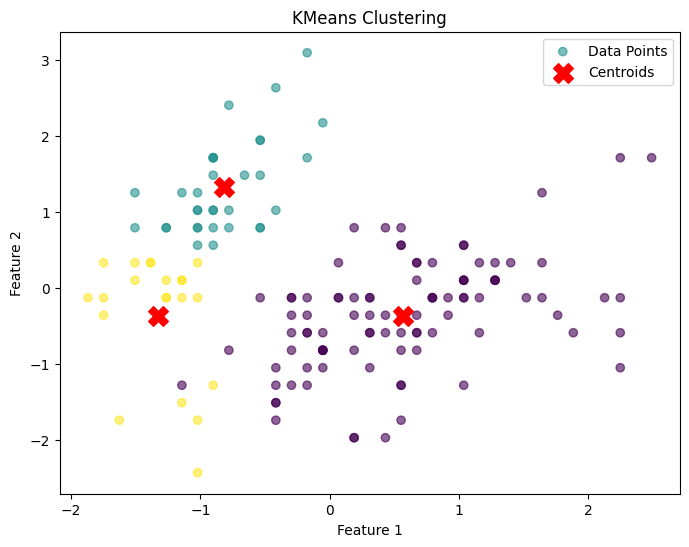

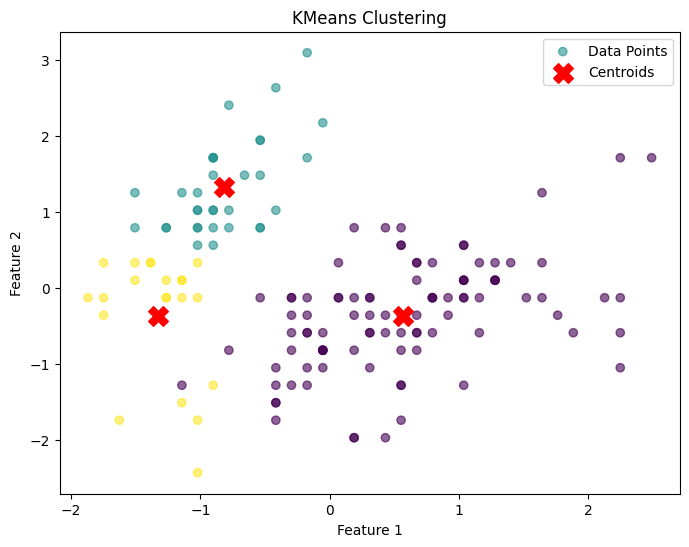

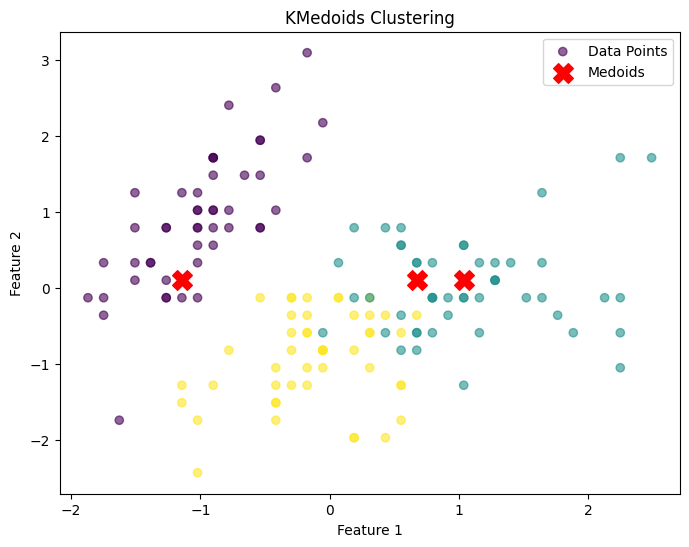

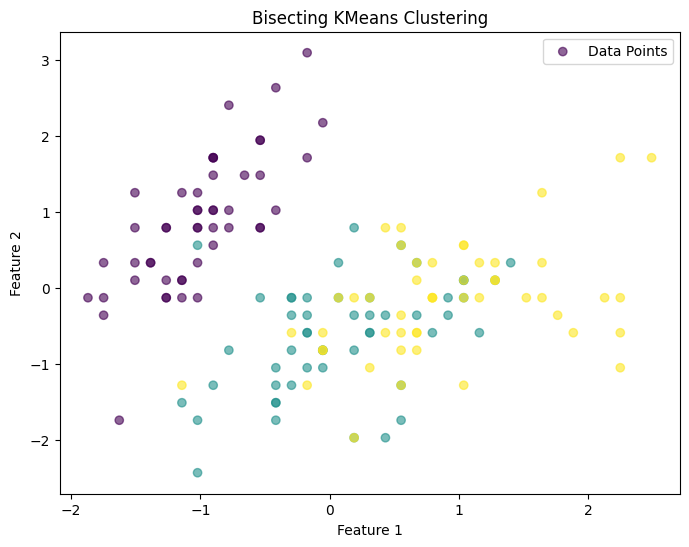

=============K-means Clustering of iris dataset=======================
KMeans Labels: [1 2 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 2 1
 1 2 1 1 2 2 1 1 2 1 2 1 1 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
KMeans++ Labels: [1 2 2 2 1 1 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 1 1 1 2 2 1
 1 2 1 1 2 2 1 1 2 1 2 1 1 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
KMedoids (pyclustering) Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 2 1 2 1 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 1 1 1 1 1 2 1 2 1 1 1

In [ ]:
#running iris dataset
# Run KMeans (basic and k-means++)
kmeans_model_iris, kmeans_labels_iris = run_kmeans(iris_scaled)
kmeans_model_pp_iris, kmeans_labels_pp_iris = run_kmeans(iris_scaled, init='k-means++')

# Run KMedoids using pyclustering
kmedoids_labels_iris = run_kmedoids_pyclustering(iris_scaled, n_clusters=3)

# Run Bisecting KMeans
bisect_labels_iris = run_bisecting_kmeans(iris_scaled, n_clusters=3)

# Displaying results
print("=============K-means Clustering of iris dataset=======================")
print("KMeans Labels:", kmeans_labels_iris)
print("KMeans++ Labels:", kmeans_labels_pp_iris)
print("KMedoids (pyclustering) Labels:", kmedoids_labels_iris)
print("Bisecting KMeans Labels:", bisect_labels_iris)

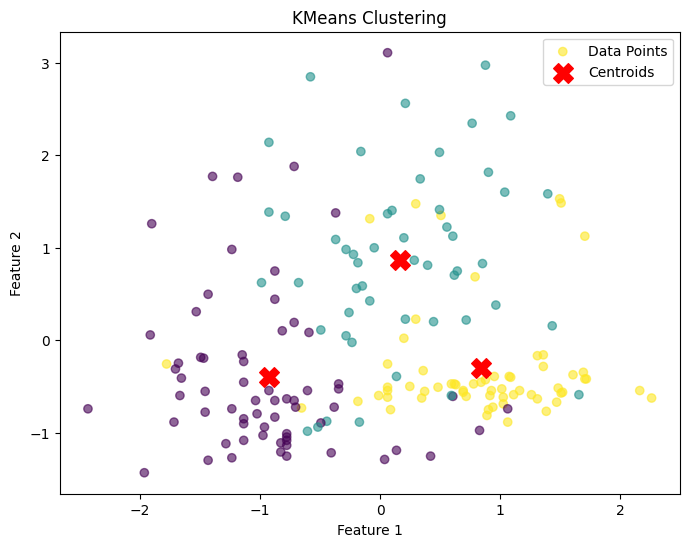

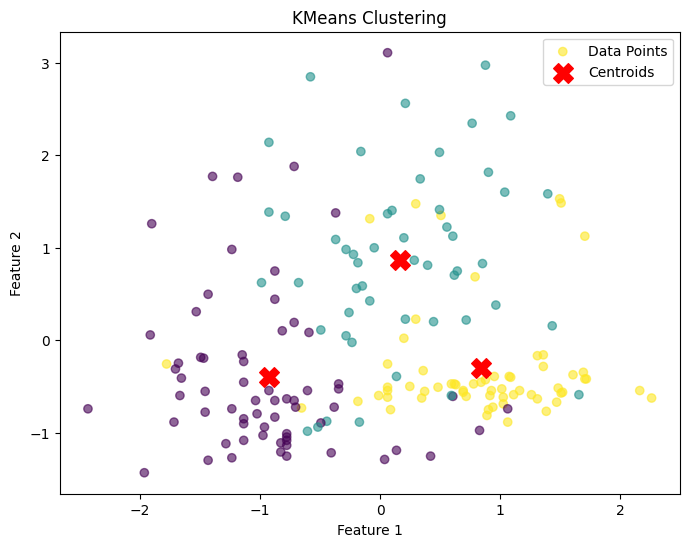

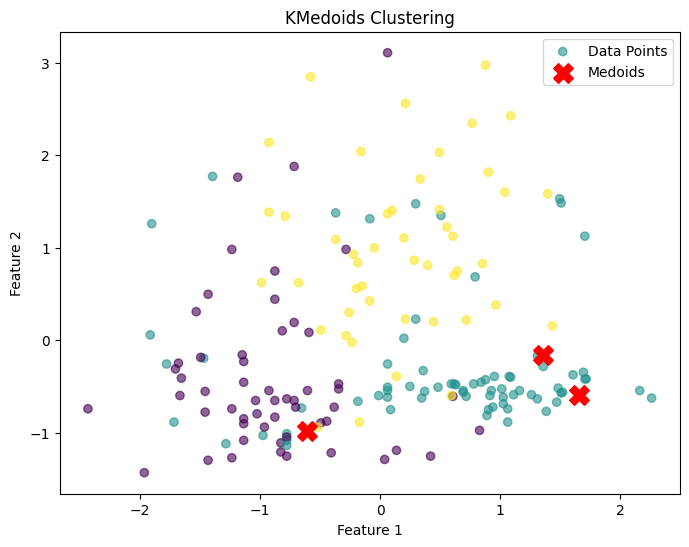

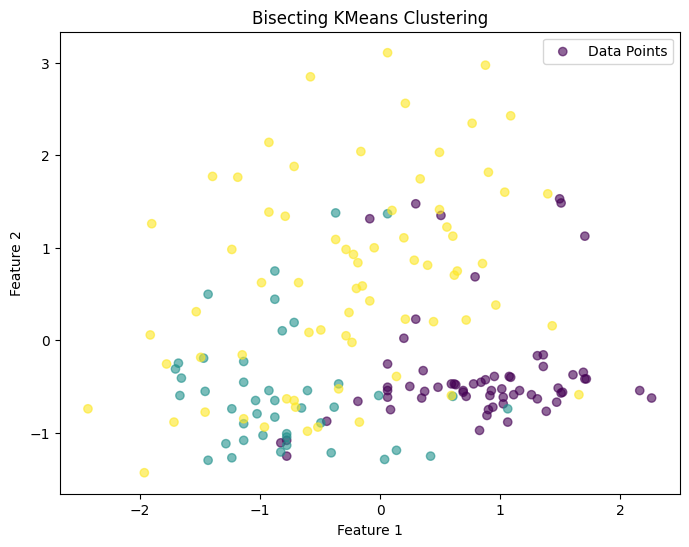

=============Clustering of wine dataset=======================
KMeans Labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
KMeans++ Labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
KMedoids (pyclustering) Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1

In [ ]:
# running wine dataset
# Run KMeans (basic and k-means++)
kmeans_model_wine, kmeans_labels_wine = run_kmeans(wine_scaled)
kmeans_model_pp_wine, kmeans_labels_pp_wine = run_kmeans(wine_scaled, init='k-means++')

# Run KMedoids using pyclustering
kmedoids_labels_wine = run_kmedoids_pyclustering(wine_scaled, n_clusters=3)

# Run Bisecting KMeans
bisect_labels_wine = run_bisecting_kmeans(wine_scaled, n_clusters=3)

# Displaying results
print("=============Clustering of wine dataset=======================")
print("KMeans Labels:", kmeans_labels_wine)
print("KMeans++ Labels:", kmeans_labels_pp_wine)
print("KMedoids (pyclustering) Labels:", kmedoids_labels_wine)
print("Bisecting KMeans Labels:", bisect_labels_wine)

## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

# Function for Hierarchical Clustering and Dendrogram Plot
def hierarchical_clustering(data, method='ward', n_clusters=3):
    """
    Apply hierarchical clustering to the given data and plot the dendrogram.

    Parameters:
    data: The input dataset (e.g., Iris or Wine dataset).
    method: The linkage method for hierarchical clustering (default is 'ward').
    n_clusters: The number of clusters to form (default is 3).

    Returns:
    labels: Cluster labels for each data point.
    """

    # Compute the linkage matrix
    linked = linkage(data, method=method)

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram(linked, truncate_mode='lastp', p=30)
    plt.title(f'Hierarchical Clustering Dendrogram ({method.capitalize()})')
    plt.xlabel('Samples')
    plt.ylabel('Distance')
    plt.show()

    # Assign clusters based on the dendrogram
    labels = fcluster(linked, n_clusters, criterion='maxclust')

    return labels




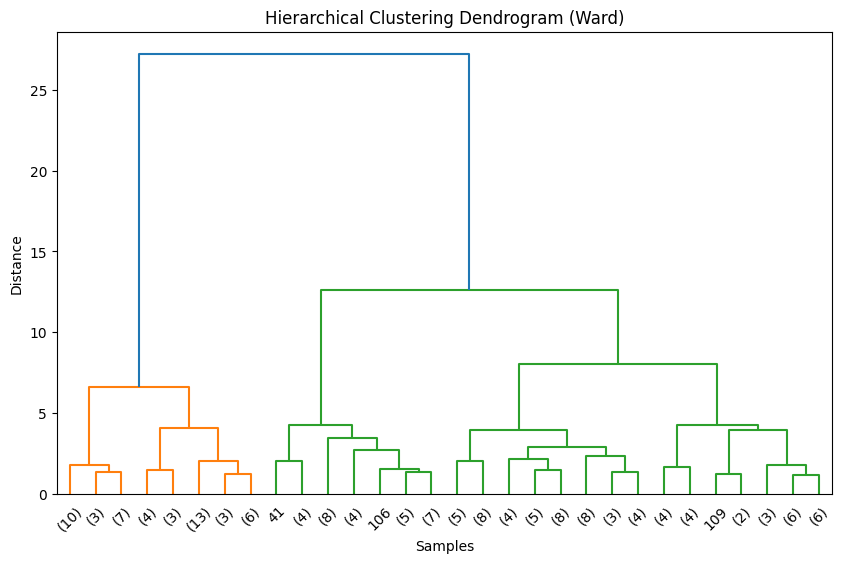

Iris Cluster Labels: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 1 3 3 3 2 3 2 3 2 3 2 2 3 2 3 2 3 2 2 2 2 3 3 3 3
 3 3 3 3 3 2 2 2 2 3 2 3 3 2 2 2 2 3 2 2 2 2 2 3 2 2 3 3 3 3 3 3 2 3 3 3 3
 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3]


In [ ]:
# Apply hierarchical clustering on Iris dataset
iris_hierarchical_labels = hierarchical_clustering(iris_scaled, method='ward', n_clusters=3)
print("Iris Cluster Labels:", iris_hierarchical_labels)

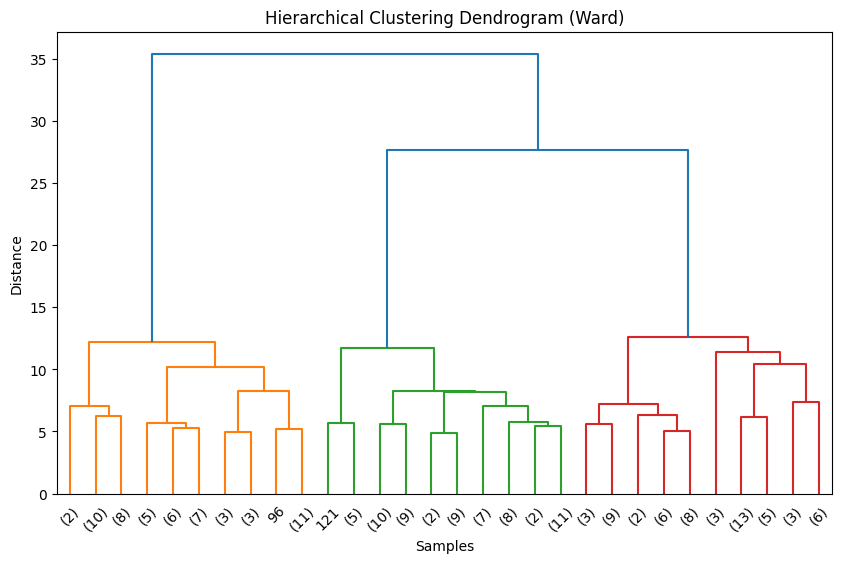

Wine Cluster Labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 1 3 3 3 2 2 3 1 3 1 2 3 2
 3 3 3 1 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 1 3 3 2 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
# Apply hierarchical clustering on Wine dataset
wine_hierarchical_labels = hierarchical_clustering(wine_scaled, method='ward', n_clusters=3)

print("Wine Cluster Labels:", wine_hierarchical_labels)

### Optical Clustering

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, OPTICS

# Function to apply DBSCAN and OPTICS clustering on a dataset
def apply_clustering(data, eps=0.5, min_samples=5, xi=0.05, min_cluster_size=0.1, plot=True):
    """
    Apply DBSCAN and OPTICS clustering on the given dataset.

    Parameters:
    data: The input dataset (e.g., Iris or Wine dataset).
    eps: The maximum distance between two samples for them to be considered as in the same neighborhood (for DBSCAN).
    min_samples: The number of samples in a neighborhood for a point to be considered as a core point (for DBSCAN and OPTICS).
    xi: The minimum steepness on the reachability plot for a cluster to be formed (for OPTICS).
    min_cluster_size: The minimum size of clusters for OPTICS.

    Returns:
    dbscan_labels: Cluster labels from DBSCAN.
    optics_labels: Cluster labels from OPTICS.
    """

    # DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)

    # OPTICS Clustering
    optics = OPTICS(min_samples=min_samples, xi=xi, min_cluster_size=min_cluster_size)
    optics_labels = optics.fit_predict(data)

    # Plotting the DBSCAN clustering results
    if plot:
        plt.figure(figsize=(12, 6))

        # Plot DBSCAN clustering results
        plt.subplot(1, 2, 1)
        unique_labels_dbscan = np.unique(dbscan_labels)
        # Core points (label >= 0)
        core_points_dbscan = data[dbscan_labels >= 0]
        # Noise points (label == -1)
        noise_points_dbscan = data[dbscan_labels == -1]

        # Plot core points in green
        plt.scatter(core_points_dbscan[:, 0], core_points_dbscan[:, 1], c='green', label='Core Points', alpha=0.6)
        # Plot noise points in black
        plt.scatter(noise_points_dbscan[:, 0], noise_points_dbscan[:, 1], c='black', label='Noise', alpha=0.6)

        plt.title("DBSCAN Clustering")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

        # Plot OPTICS clustering results
        plt.subplot(1, 2, 2)
        unique_labels_optics = np.unique(optics_labels)
        # Core points (label >= 0)
        core_points_optics = data[optics_labels >= 0]
        # Noise points (label == -1)
        noise_points_optics = data[optics_labels == -1]

        # Plot core points in blue
        plt.scatter(core_points_optics[:, 0], core_points_optics[:, 1], c='blue', label='Core Points', alpha=0.6)
        # Plot noise points in red
        plt.scatter(noise_points_optics[:, 0], noise_points_optics[:, 1], c='red', label='Noise', alpha=0.6)

        plt.title("OPTICS Clustering")
        plt.xlabel("Feature 1")
        plt.ylabel("Feature 2")

        # Add legend
        plt.subplot(1, 2, 1)
        plt.legend(loc='upper right')
        plt.subplot(1, 2, 2)
        plt.legend(loc='upper right')

        # Show the plots
        plt.tight_layout()
        plt.show()

    return dbscan_labels, optics_labels


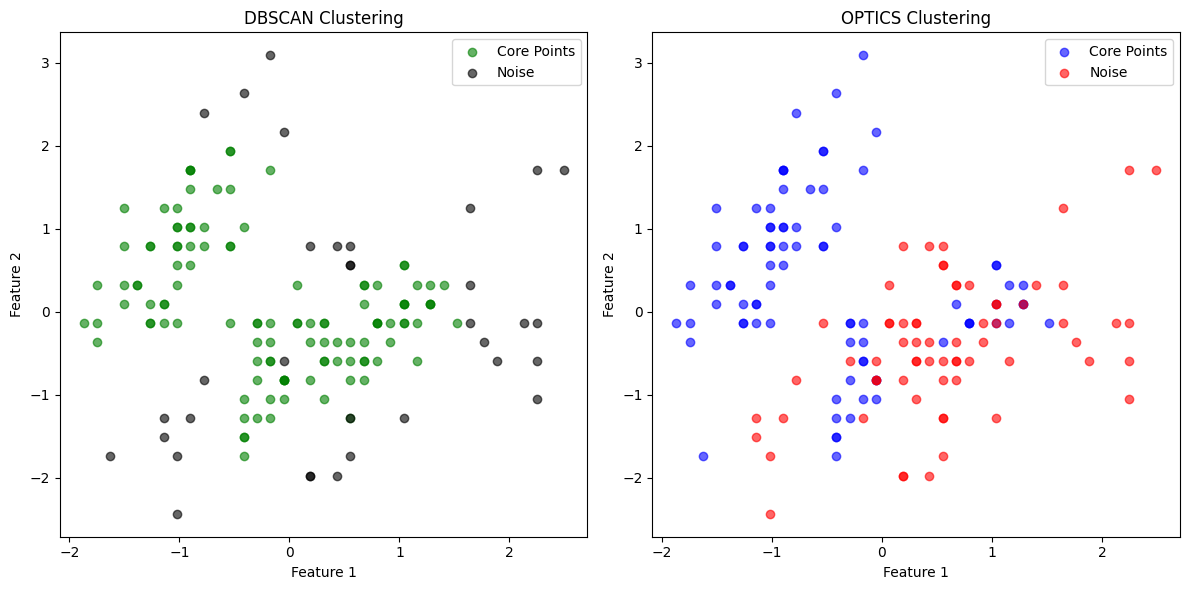

Iris DBSCAN Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1 -1 -1  1 -1 -1  1 -1  1  1  1  1  1 -1  1  1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1
  1  1 -1  1  1 -1  1  1  1 -1 -1 -1  1  1  1 -1 -1  1  1  1  1  1  1  1
  1  1  1  1 -1  1]
Iris OPTICS Labels: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1  1  1  1 -1  1 -1  1  1
  1 -1 -1  1 -1 -1  2  2  2 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  2 -1 -1 -1
  2 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1  2  2  2 -1  2
  2  2 -1  2 -1 -1]


In [ ]:
# Apply clustering on the Iris dataset
iris_dbscan_labels, iris_optics_labels = apply_clustering(iris_scaled, eps=0.5, min_samples=5, xi=0.05, min_cluster_size=0.1)
print("Iris DBSCAN Labels:", iris_dbscan_labels)
print("Iris OPTICS Labels:", iris_optics_labels)

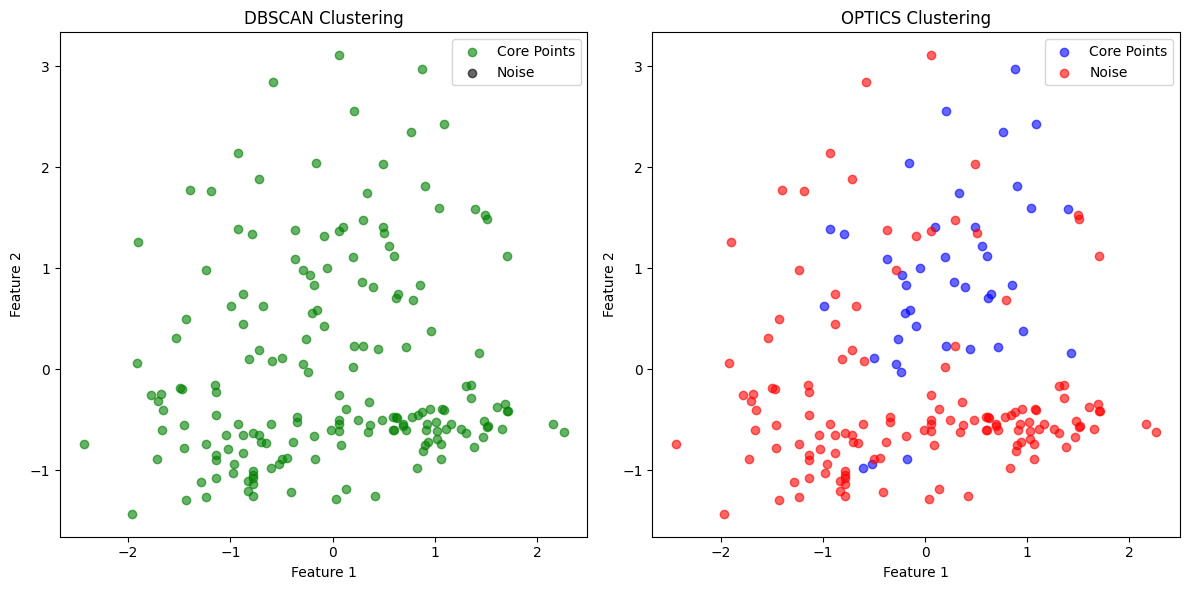

Wine DBSCAN Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Wine OPTICS Labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0  0
  0 -1  0  0  0  0  0  0  0  0]


In [ ]:

# Apply clustering on the Wine dataset
wine_dbscan_labels, wine_optics_labels = apply_clustering(wine_scaled, eps=10.5, min_samples=5, xi=0.05, min_cluster_size=0.1)

print("Wine DBSCAN Labels:", wine_dbscan_labels)
print("Wine OPTICS Labels:", wine_optics_labels)

### Evaluation Metrics

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score, rand_score,
    mutual_info_score, adjusted_mutual_info_score, normalized_mutual_info_score,
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import numpy as np
from scipy.stats import mode

# Helper: Evaluation function with Rand, MI, and cluster quality metrics
def evaluate(true_labels, predicted_labels, data):

    # Check if there are multiple labels (valid clusters)
    if len(np.unique(predicted_labels)) < 2:
        print("Invalid clustering: Only one cluster found. Skipping evaluation for this model.")
        return {}

    # Compute metrics if valid clustering found
    return {
        "Rand Index": rand_score(true_labels, predicted_labels),
        "Adjusted Rand Index": adjusted_rand_score(true_labels, predicted_labels),
        "Mutual Info": mutual_info_score(true_labels, predicted_labels),
        "Adjusted MI": adjusted_mutual_info_score(true_labels, predicted_labels),
        "Normalized MI": normalized_mutual_info_score(true_labels, predicted_labels),
        "Silhouette": silhouette_score(data, predicted_labels),
        "Calinski-Harabasz": calinski_harabasz_score(data, predicted_labels),
        "Davies-Bouldin": davies_bouldin_score(data, predicted_labels),
    }

# Evaluate all models for the Iris dataset
iris_results = {
    "KMeans": evaluate(iris_labels, kmeans_labels_iris, iris_scaled),
    "KMeans++": evaluate(iris_labels, kmeans_labels_pp_iris, iris_scaled),
    "Bisecting KMeans": evaluate(iris_labels, bisect_labels_iris, iris_scaled),
    "KMedoids": evaluate(iris_labels, kmedoids_labels_iris, iris_scaled),
    "Hierarchical": evaluate(iris_labels, iris_hierarchical_labels, iris_scaled),
    "DBSCAN": evaluate(iris_labels, iris_dbscan_labels, iris_scaled),
    "OPTICS": evaluate(iris_labels, iris_optics_labels, iris_scaled),
}

# Evaluate all models for the Wine dataset
wine_results = {
    "KMeans": evaluate(wine_labels, kmeans_labels_wine, wine_scaled),
    "KMeans++": evaluate(wine_labels, kmeans_labels_pp_wine, wine_scaled),
    "Bisecting KMeans": evaluate(wine_labels, bisect_labels_wine, wine_scaled),
    "KMedoids": evaluate(wine_labels, kmedoids_labels_wine, wine_scaled),
    "Hierarchical": evaluate(wine_labels, wine_hierarchical_labels, wine_scaled),
    "DBSCAN": evaluate(wine_labels, wine_dbscan_labels, wine_scaled),
    "OPTICS": evaluate(wine_labels, wine_optics_labels, wine_scaled),
}




Invalid clustering: Only one cluster found. Skipping evaluation for this model.


In [ ]:
from prettytable import PrettyTable

# Function to display results in PrettyTable format
def print_pretty_table(results, dataset_name="Dataset"):
    # Prepare a list of metrics for each model
    metrics = ["Rand Index", "Adjusted Rand Index", "Mutual Info", "Adjusted MI", "Normalized MI",
               "Silhouette", "Calinski-Harabasz", "Davies-Bouldin"]

    # Create the table
    table = PrettyTable()

    # Set the headers (metric names and clustering models)
    table.field_names = ["Metric"] + list(results.keys())

    # Add rows for each metric
    for metric in metrics:
        row = [metric]
        for model in results:
            value = results[model].get(metric, None)  # Get the value or None if the metric is missing
            row.append(value)
        table.add_row(row)

    # Display the table
    print(f"================= {dataset_name} dataset evaluation metrics =================")
    print(table)

# Display the evaluation results for Iris dataset
print_pretty_table(iris_results, dataset_name="Iris")

# Display the evaluation results for Wine dataset
print_pretty_table(wine_results, dataset_name="Wine")


================= Iris dataset evaluation metrics =================
+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
|        Metric       |        KMeans       |       KMeans++      |  Bisecting KMeans  |      KMedoids      |    Hierarchical    |        DBSCAN       |        OPTICS       |
+---------------------+---------------------+---------------------+--------------------+--------------------+--------------------+---------------------+---------------------+
|      Rand Index     |  0.7289485458612975 |  0.7289485458612975 | 0.8708724832214765 | 0.8737360178970918 | 0.7894407158836689 |  0.7633109619686801 |  0.8112751677852349 |
| Adjusted Rand Index | 0.44912895631626226 | 0.44912895631626226 | 0.7114161813530885 | 0.7179544473874414 | 0.541263464564624  | 0.48247595559429524 |  0.5786895646109799 |
|     Mutual Info     |  0.5805580464111272 |  0.58055804

### Cohesion and Separation (SSE & SSB)

In [ ]:
def sse(data, labels, centers=None):
    if centers is None:
        centers = [data[labels == i].mean(axis=0) for i in np.unique(labels)]
    return sum(np.sum((data[labels == i] - center)**2) for i, center in enumerate(centers))

def ssb(data, labels):
    overall_mean = np.mean(data, axis=0)
    unique_labels = np.unique(labels)
    return sum(len(data[labels == l]) * np.sum((np.mean(data[labels == l], axis=0) - overall_mean) ** 2)
               for l in unique_labels)






In [ ]:
kmeans_sse_iris = sse(iris_scaled, kmeans_labels_iris, kmeans_model_iris.cluster_centers_)
kmeans_ssb_iris = ssb(iris_scaled, kmeans_labels_iris)
kmedoids_sse_iris = sse(iris_scaled, kmedoids_labels_iris, kmeans_model_iris.cluster_centers_)
kmedoids_ssb_iris = ssb(iris_scaled, kmedoids_labels_iris)
bisecting_kmeans_sse_iris = sse(iris_scaled, bisect_labels_iris, kmeans_model_iris.cluster_centers_)
bisecting_kmeans_ssb_iris = ssb(iris_scaled, bisect_labels_iris)
hierarchical_sse_iris = sse(iris_scaled, iris_hierarchical_labels, kmeans_model_iris.cluster_centers_)
hierarchical_ssb_iris = ssb(iris_scaled, iris_hierarchical_labels)
dbscan_sse_iris = sse(iris_scaled, iris_dbscan_labels, kmeans_model_iris.cluster_centers_)
dbscan_ssb_iris = ssb(iris_scaled, iris_dbscan_labels)
optics_sse_iris = sse(iris_scaled, iris_optics_labels, kmeans_model_iris.cluster_centers_)
optics_ssb_iris = ssb(iris_scaled, iris_optics_labels)


from prettytable import PrettyTable

# Create the table object
table = PrettyTable()

# Define the column names
table.field_names = ["Clustering Algorithm", "SSE", "SSB"]

# Add rows for each model with their respective SSE and SSB values
table.add_row(["KMeans", f"{kmeans_sse_iris:.2f}", f"{kmeans_ssb_iris:.2f}"])
table.add_row(["KMedoids", f"{kmedoids_sse_iris:.2f}", f"{kmedoids_ssb_iris:.2f}"])
table.add_row(["Bisecting KMeans", f"{bisecting_kmeans_sse_iris:.2f}", f"{bisecting_kmeans_ssb_iris:.2f}"])
table.add_row(["Hierarchical", f"{hierarchical_sse_iris:.2f}", f"{hierarchical_ssb_iris:.2f}"])
table.add_row(["DBSCAN", f"{dbscan_sse_iris:.2f}", f"{dbscan_ssb_iris:.2f}"])
table.add_row(["OPTICS", f"{optics_sse_iris:.2f}", f"{optics_ssb_iris:.2f}"])

# Print the table
print(table)

+----------------------+---------+--------+
| Clustering Algorithm |   SSE   |  SSB   |
+----------------------+---------+--------+
|        KMeans        |  191.02 | 408.98 |
|       KMedoids       | 1075.37 | 459.27 |
|   Bisecting KMeans   | 1924.09 | 426.09 |
|     Hierarchical     |  204.40 | 451.12 |
|        DBSCAN        | 1410.74 | 320.90 |
|        OPTICS        | 1035.48 | 418.35 |
+----------------------+---------+--------+


In [ ]:
kmeans_sse_wine = sse(wine_scaled, kmeans_labels_wine, kmeans_model_wine.cluster_centers_)
kmeans_ssb_wine = ssb(wine_scaled, kmeans_labels_wine)
kmedoids_sse_wine = sse(wine_scaled, kmedoids_labels_wine, kmeans_model_wine.cluster_centers_)
kmedoids_ssb_wine = ssb(wine_scaled, kmedoids_labels_wine)
bisecting_kmeans_sse_wine = sse(wine_scaled, bisect_labels_wine, kmeans_model_wine.cluster_centers_)
bisecting_kmeans_ssb_wine = ssb(wine_scaled, bisect_labels_wine)
hierarchical_sse_wine = sse(wine_scaled, wine_hierarchical_labels, kmeans_model_wine.cluster_centers_)
hierarchical_ssb_wine = ssb(wine_scaled, wine_hierarchical_labels)
dbscan_sse_wine = sse(wine_scaled, wine_dbscan_labels, kmeans_model_wine.cluster_centers_)
dbscan_ssb_wine = ssb(wine_scaled, wine_dbscan_labels)
optics_sse_wine = sse(wine_scaled, wine_optics_labels, kmeans_model_wine.cluster_centers_)
optics_ssb_wine = ssb(wine_scaled, wine_optics_labels)

from prettytable import PrettyTable

# Create the table object
table = PrettyTable()

# Define the column names
table.field_names = ["Clustering Algorithm", "SSE", "SSB"]

# Add rows for each model with their respective SSE and SSB values
table.add_row(["KMeans", f"{kmeans_sse_wine:.2f}", f"{kmeans_ssb_wine:.2f}"])
table.add_row(["KMedoids", f"{kmedoids_sse_wine:.2f}", f"{kmedoids_ssb_wine:.2f}"])
table.add_row(["Bisecting KMeans", f"{bisecting_kmeans_sse_wine:.2f}", f"{bisecting_kmeans_ssb_wine:.2f}"])
table.add_row(["Hierarchical", f"{hierarchical_sse_wine:.2f}", f"{hierarchical_ssb_wine:.2f}"])
table.add_row(["DBSCAN", f"{dbscan_sse_wine:.2f}", f"{dbscan_ssb_wine:.2f}"])
table.add_row(["OPTICS", f"{optics_sse_wine:.2f}", f"{optics_ssb_wine:.2f}"])

# Print the table
print(table)


+----------------------+---------+---------+
| Clustering Algorithm |   SSE   |   SSB   |
+----------------------+---------+---------+
|        KMeans        | 1277.93 | 1036.07 |
|       KMedoids       | 4115.98 | 1004.52 |
|   Bisecting KMeans   | 4320.49 |  741.40 |
|     Hierarchical     |  816.60 | 1008.95 |
|        DBSCAN        |   0.00  |   0.00  |
|        OPTICS        |  889.37 |  493.01 |
+----------------------+---------+---------+
